# Generalization: reflecting boundaries
<div id="wave:pde2:Neumann"></div>

The boundary condition $u=0$ in a wave equation reflects the wave, but
$u$ changes sign at the boundary, while the condition $u_x=0$ reflects
the wave as a mirror and preserves the sign, see a [web page](mov-wave/demo_BC_gaussian/index.html) or a
[movie file](mov-wave/demo_BC_gaussian/movie.flv) for
demonstration.


Our next task is to explain how to implement the boundary
condition $u_x=0$, which is
more complicated to express numerically and also to implement than
a given value of $u$.
We shall present two methods for implementing $u_x=0$
in a finite difference scheme, one based on deriving a modified
stencil at the boundary, and another one based on extending the mesh
with ghost cells and ghost points.


## Neumann boundary condition
<div id="wave:pde2:Neumann:bc"></div>


When a wave hits a boundary and is to be reflected back, one applies
the condition

<!-- Equation labels as ordinary links -->
<div id="wave:pde1:Neumann:0"></div>

$$
\begin{equation}
 \frac{\partial u}{\partial n} \equiv \boldsymbol{n}\cdot\nabla u = 0
\label{wave:pde1:Neumann:0} \tag{1}
\thinspace .
\end{equation}
$$

The derivative $\partial /\partial n$ is in the
outward normal direction from a general boundary.
For a 1D domain $[0,L]$,
we have that

$$
\left.\frac{\partial}{\partial n}\right\vert_{x=L} =
\left.\frac{\partial}{\partial x}\right\vert_{x=L},\quad
\left.\frac{\partial}{\partial n}\right\vert_{x=0} = -
\left.\frac{\partial}{\partial x}\right\vert_{x=0}\thinspace .
$$

**Boundary condition terminology.**

Boundary conditions
that specify the value of $\partial u/\partial n$
(or shorter $u_n$) are known as
[Neumann](http://en.wikipedia.org/wiki/Neumann_boundary_condition) conditions, while [Dirichlet conditions](http://en.wikipedia.org/wiki/Dirichlet_conditions)
refer to specifications of $u$.
When the values are zero ($\partial u/\partial n=0$ or $u=0$) we speak
about *homogeneous* Neumann or Dirichlet conditions.



## Discretization of derivatives at the boundary
<div id="wave:pde2:Neumann:discr"></div>


How can we incorporate the condition ([1](#wave:pde1:Neumann:0))
in the finite difference scheme?  We can see that, on the boundary

<!-- Equation labels as ordinary links -->
<div id="wave:pde1:Neumann:0:cd"></div>

$$
\begin{equation}
u_x \approx \frac{u_1^n - u_0^n}{\Delta x} = 0
\thinspace .
\label{wave:pde1:Neumann:0:cd} \tag{2}
\end{equation}
$$

Therefore, we can pass the following equation as a boundary condition to the Devito `Operator`:
```python
bc = [Eq(u[t_s+1, 0], u[t_s+1, 1])]
```
## Solver
Now, let's take a look at the full Devito solver function. The solver is very similar to the one in the waves [Implementation](wave1D_prog.ipynb) section, except for the boundary condition.

In [4]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
import time as time
import matplotlib.pyplot as plt
from devito import Constant, Grid, TimeFunction, SparseTimeFunction, Function, Eq, solve, Operator, Buffer

In [5]:
def python_solver(I, V, f, c, L, dt, C, T, user_action=None):
    """
    Solve u_tt=c^2*u_xx + f on (0,L)x(0,T].
    u(0,t)=U_0(t) or du/dn=0 (U_0=None), u(L,t)=U_L(t) or du/dn=0 (u_L=None).
    """
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2; dt2 = dt*dt            # Help variables in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Wrap user-given f, V
    if f is None or f == 0:
        f = (lambda x, t: 0)
    if V is None or V == 0:
        V = (lambda x: 0)

    u     = np.zeros(Nx+1)   # Solution array at new time level
    u_n   = np.zeros(Nx+1)   # Solution at 1 time level back
    u_nm1 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.perf_counter()  # CPU time measurement

    # Load initial condition into u_n
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])
    print(u_n)

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Special formula for the first step
    for i in range(0, Nx+1):
        ip1 = i+1 if i < Nx else i-1
        im1 = i-1 if i > 0  else i+1
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
               0.5*dt2*f(x[i], t[0])
    print(u)

    if user_action is not None:
        user_action(u, x, t, 1)

    # Update data structures for next step
    #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
    u_nm1, u_n, u = u_n, u, u_nm1

    for n in range(1, Nt):
        for i in range(0, Nx+1):
            ip1 = i+1 if i < Nx else i-1
            im1 = i-1 if i > 0  else i+1
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                   C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
                   dt2*f(x[i], t[n])

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Update data structures for next step
        #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
        u_nm1, u_n, u = u_n, u, u_nm1

    # Wrong assignment u = u_nm1 must be corrected before return
    u = u_n
    cpu_time = time.perf_counter() - t0
    return u, x, t, cpu_time

In [19]:
# %load -s solver, src-wave/wave1D/wave1D_n0.py
def solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Initialising functions f and V if not provided
    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0
        
    t0 = time.perf_counter()  # Measure CPU time

    # Set up grid
    grid = Grid(shape=(Nx+1), extent=(L))
    t_s = grid.stepping_dim
        
    # Create and initialise u
    u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)
    for i in range(Nx+1):
        u.data[:,i] = I(x[i])
    print(u.data[0])

    x_dim = grid.dimensions[0]
    t_dim = grid.time_dim
    
    # The wave equation we are trying to solve
    pde = (1/c**2)*u.dt2-u.dx2
    
    # Source term and injection into equation
    dt_symbolic = grid.time_dim.spacing    
    src = SparseTimeFunction(name='f', grid=grid, npoint=Nx+1, nt=Nt+1)
    
    for i in range(Nt):
        src.data[i] = f(x, t[i])
    
    src.coordinates.data[:, 0] = x
    src_term = src.inject(field=u.forward, expr=src * (dt_symbolic**2))
    stencil = Eq(u.forward, solve(pde, u.forward))

    # Set up special stencil for initial timestep with substitution for u.backward
    v = Function(name='v', grid=grid, npoint=Nx+1, nt=1)
    v.data[:] = V(x[:])
    stencil_init = stencil.subs(u.backward, u.forward - dt_symbolic*v)

    # Boundary condition
    bc = [Eq(u[t_s+1, 0], u[t_s+1, 1])]
    bc += [Eq(u[t_s+1, Nx], u[t_s+1, Nx-1])]

    # Create and apply operators
    op_init = Operator([stencil_init]+bc+src_term)
    op = Operator([stencil]+bc+src_term)
    
    op_init.apply(time_M=1, dt=dt)
    
    op.apply(time_m=1, time_M=Nt, dt=dt)
    print("u.data", u.data)
    cpu_time = time.perf_counter() - t0
    
    return u.data[1], x, t, cpu_time


[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s
Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s


u.data [[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


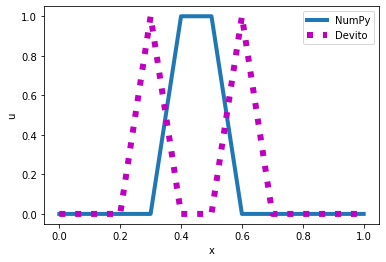

In [21]:
# NBVAL_IGNORE_OUTPUT
L = 1.0
I = lambda y: 0 if abs(y-L/2.0) > 0.1 else 1

Nx = 10
c = 0.5
C = 1
dt = C*(L/Nx)/c
nperiods = 4
T = L/c*nperiods  # One period: c*T = L
Nt = int(round(T/dt))
x = np.linspace(0, L, Nx+1)       # Mesh points in space

L = 1.0
c = 0.5
dt = (L/10)/c  # Nx=10
I = lambda x: 0 if abs(x-L/2.0) > 0.1 else 1
# I = lambda x: 5*x
U_0 = lambda t: t
T = 4


u_mine, x_arr, t_arr, cpu_time = solver(I, None, None, c, L, dt, C, T)
u, x, t, cpu = python_solver(I, None, None, c, L, dt, C, T)

plt.plot(x, u, label='NumPy', linewidth=4)
plt.plot(x_arr, u_mine, 'm:', label='Devito', linewidth=6)
plt.xlabel('x')
plt.ylabel('u')
plt.legend(loc='best')
plt.show()

The program [`wave1D_n0.py`](src-wave/wave1D/wave1D_n0.py)
also contains this solver function.

It would be nice to modify the `test_quadratic` test case from the
`wave1D_u0.py` with Dirichlet conditions, described in the section on [verification](wave1D_prog.ipynb#wave:pde1:impl:vec:verify:quadratic). However, the Neumann
conditions require the polynomial variation in the $x$ direction to
be of third degree, which causes challenging problems when
designing a test where the numerical solution is known exactly.
[Exercise 9: Verification by a cubic polynomial in space](#wave:fd2:exer:verify:cubic) outlines ideas and code
for this purpose. The only test in `wave1D_n0.py` is to start
with a plug wave at rest and see that the initial condition is
reached again perfectly after one period of motion, but such
a test requires $C=1$ (so the numerical solution coincides with
the exact solution of the PDE, see the section [Numerical dispersion relation](wave_analysis.ipynb#wave:pde1:num:dispersion)).


**Notice.**

The program [`wave1D_dn.py`](src-wave/wave1D/wave1D_dn.py)
solves the 1D wave equation $u_{tt}=c^2u_{xx}+f(x,t)$ with
quite general boundary and initial conditions:

  * $x=0$: $u=U_0(t)$ or $u_x=0$

  * $x=L$: $u=U_L(t)$ or $u_x=0$

  * $t=0$: $u=I(x)$

  * $t=0$: $u_t=V(x)$

A lot of test examples are also included in the program:

 * A rectangular plug-shaped initial condition. (For $C=1$ the solution
   will be a rectangle that jumps one cell per time step, making the case
   well suited for verification.)

 * A Gaussian function as initial condition.

 * A triangular profile as initial condition, which resembles the
   typical initial shape of a guitar string.

 * A sinusoidal variation of $u$ at $x=0$ and either $u=0$ or
   $u_x=0$ at $x=L$.

 * An analytical solution $u(x,t)=\cos(m\pi t/L)\sin({\frac{1}{2}}m\pi x/L)$, which can be used for convergence rate tests.




In [131]:
import numpy as np
import matplotlib.pyplot as plt
import time
from devito import Constant, Grid, TimeFunction, SparseTimeFunction, Function, Eq, solve, Operator, Buffer

In [132]:
# %load -s python_solver, src-wave/wave1D/wave1D_dn.py
def python_solver(I, V, f, c, U_0, U_L, L, dt, C, T,
           user_action=None, version='scalar'):
    """
    Solve u_tt=c^2*u_xx + f on (0,L)x(0,T].
    u(0,t)=U_0(t) or du/dn=0 (U_0=None), u(L,t)=U_L(t) or du/dn=0 (u_L=None).
    """
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2; dt2 = dt*dt            # Help variables in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Wrap user-given f, I, V, U_0, U_L if None or 0
    if f is None or f == 0:
        f = (lambda x, t: 0) if version == 'scalar' else \
            lambda x, t: np.zeros(x.shape)
    if I is None or I == 0:
        I = (lambda x: 0) if version == 'scalar' else \
            lambda x: np.zeros(x.shape)
    if V is None or V == 0:
        V = (lambda x: 0) if version == 'scalar' else \
            lambda x: np.zeros(x.shape)
    if U_0 is not None:
        if isinstance(U_0, (float,int)) and U_0 == 0:
            U_0 = lambda t: 0
        # else: U_0(t) is a function
    if U_L is not None:
        if isinstance(U_L, (float,int)) and U_L == 0:
            U_L = lambda t: 0
        # else: U_L(t) is a function

    u     = np.zeros(Nx+1)   # Solution array at new time level
    u_n   = np.zeros(Nx+1)   # Solution at 1 time level back
    u_nm1 = np.zeros(Nx+1)   # Solution at 2 time levels back

    Ix = list(range(0, Nx+1))
    It = list(range(0, Nt+1))

    import time;  t0 = time.perf_counter()  # CPU time measurement

    # Load initial condition into u_n
    for i in Ix:
        u_n[i] = I(x[i])

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Special formula for the first step
    for i in Ix[1:-1]:
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + \
               0.5*dt2*f(x[i], t[0])

    i = Ix[0]
    if U_0 is None:
        # Set boundary values du/dn = 0
        # x=0: i-1 -> i+1 since u[i-1]=u[i+1]
        # x=L: i+1 -> i-1 since u[i+1]=u[i-1])
        ip1 = i+1
        im1 = ip1  # i-1 -> i+1
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
               0.5*dt2*f(x[i], t[0])
    else:
        u[0] = U_0(dt)

    i = Ix[-1]
    if U_L is None:
        im1 = i-1
        ip1 = im1  # i+1 -> i-1
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
               0.5*dt2*f(x[i], t[0])
    else:
        u[i] = U_L(dt)

    if user_action is not None:
        user_action(u, x, t, 1)

    # Update data structures for next step
    #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
    u_nm1, u_n, u = u_n, u, u_nm1

    for n in It[1:-1]:
        # Update all inner points
        if version == 'scalar':
            for i in Ix[1:-1]:
                u[i] = - u_nm1[i] + 2*u_n[i] + \
                       C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + \
                       dt2*f(x[i], t[n])

        elif version == 'vectorized':
            u[1:-1] = - u_nm1[1:-1] + 2*u_n[1:-1] + \
                      C2*(u_n[0:-2] - 2*u_n[1:-1] + u_n[2:]) + \
                      dt2*f(x[1:-1], t[n])
        else:
            raise ValueError('version=%s' % version)

        # Insert boundary conditions
        i = Ix[0]
        if U_0 is None:
            # Set boundary values
            # x=0: i-1 -> i+1 since u[i-1]=u[i+1] when du/dn=0
            # x=L: i+1 -> i-1 since u[i+1]=u[i-1] when du/dn=0
            ip1 = i+1
            im1 = ip1
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                   C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
                   dt2*f(x[i], t[n])
        else:
            u[0] = U_0(t[n+1])

        i = Ix[-1]
        if U_L is None:
            im1 = i-1
            ip1 = im1
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                   C2*(u_n[im1] - 2*u_n[i] + u_n[ip1]) + \
                   dt2*f(x[i], t[n])
        else:
            u[i] = U_L(t[n+1])

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Update data structures for next step
        #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
        u_nm1, u_n, u = u_n, u, u_nm1

    # Important to correct the mathematically wrong u=u_nm1 above
    # before returning u
    u = u_n
    cpu_time = time.perf_counter() - t0
    return u, x, t, cpu_time


In [148]:
# %load -s solver, src-wave/wave1D/wave1D_dn.py
def devito_solver(I, V, f, c, U_0, U_L, L, dt, C, T,
           user_action=None, version='scalar'):
    """
    Solve u_tt=c^2*u_xx + f on (0,L)x(0,T].
    u(0,t)=U_0(t) or du/dn=0 (U_0=None), u(L,t)=U_L(t) or du/dn=0 (u_L=None).
    """
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme

    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Wrap user-given f, I, V, U_0, U_L if None or 0
    if f is None or f == 0:
        f = (lambda x, t: 0) if version == 'scalar' else \
            lambda x, t: np.zeros(x.shape)
    if I is None or I == 0:
        I = (lambda x: 0) if version == 'scalar' else \
            lambda x: np.zeros(x.shape)
    if V is None or V == 0:
        V = (lambda x: 0) if version == 'scalar' else \
            lambda x: np.zeros(x.shape)
    if U_0 is not None:
        if isinstance(U_0, (float,int)) and U_0 == 0:
            U_0 = lambda t: 0
        # else: U_0(t) is a function
    else:
        U_0 = lambda t: 0
    if U_L is not None:
        if isinstance(U_L, (float,int)) and U_L == 0:
            U_L = lambda t: 0
    else:
        U_L = lambda t: 0
        # else: U_L(t) is a function

    t0 = time.perf_counter()  # Measure CPU time
    
    # Set up grid
    grid = Grid(shape=(Nx+1), extent=(L))
    t_s = grid.stepping_dim
    
    # Create and initialise u
    u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)
    print(u.data.shape)
    u.data[:] = I(x)
#     for i in range(Nx+1):
#         u.data[:,i] = I(x[i])

    x_dim = grid.dimensions[0]
    t_dim = grid.time_dim
    
    # The wave equation we are trying to solve
    pde = (1/c**2)*u.dt2-u.dx2
    
    # Source term and injection into equation
    dt_symbolic = grid.time_dim.spacing    
    src = SparseTimeFunction(name='f', grid=grid, npoint=Nx+1, nt=Nt+1)

    for i in range(Nt):
        src.data[i] = f(x, t[i])

    src.coordinates.data[:, 0] = x
    src_term = src.inject(field=u.forward, expr=src * (dt_symbolic**2))
    stencil = Eq(u.forward, solve(pde, u.forward))
    
    # Set up special stencil for initial timestep with substitution for u.backward
    v = Function(name='v', grid=grid, npoint=Nx+1, nt=1)
    v.data[:] = V(x[:])
    stencil_init = stencil.subs(u.backward, u.forward - dt_symbolic*v)
    
    import inspect
#     print(inspect.getsource(U_0))
    
    u0 = Function(name='u0', grid=grid, npoint=1)
#     print(u0.data.shape)
    # Boundary conditions, depending on arguments
    bc = []
#     if U_0 is None and U_L is None:
    bc += [Eq(u[t_s+1, 0], u[t_s+1, 1])]
    bc += [Eq(u[t_s+1, Nx], u[t_s+1, Nx-1])]
#     else:
#         if U_0 is not None:
#     bc += [Eq(u[t_s+1, 0], U_0(t_s+1))]
#         if U_L is not None:
#     bc += [Eq(u[t_s+1, L], U_L(t_s+1))]

#     bc = [Eq(u[t_s+1, 0], -u[t_s+1, 1])]

            
#     print(bc)
    
    op_init = Operator([stencil_init]+src_term+bc)
    op = Operator([stencil]+src_term+bc)
    
    op_init.apply(time_M=1, dt=dt)
    op.apply(time_m=1,time_M=Nt, dt=dt)

    cpu_time = time.perf_counter() - t0
    return u.data[1], x, t, cpu_time


(3, 11)


Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s
Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s


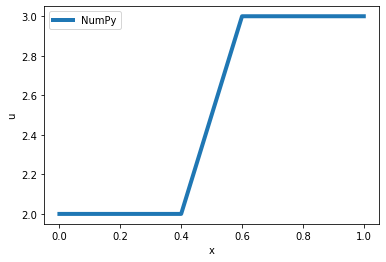

In [159]:
L = 1.0
c = 0.5
dt = (L/10)/c  # Nx=10
# I = lambda x: 0 if abs(x-L/2.0) > 0.1 else 1
I = lambda x: 5*x
U_0 = lambda t: t
T = 4


u, x, t, cpu = devito_solver(
        I=I,
        V=None, f=None, c=0.5, U_0=None, U_L=None, L=L,
        dt=dt, C=1, T=dt, user_action=None)

u_corr, x_corr, t_corr, cpu_corr = python_solver(
        I=I,
        V=None, f=None, c=0.5, U_0=None, U_L=None, L=L,
        dt=dt, C=1, T=4*dt, user_action=None)

plt.plot(x_corr, u_corr, label='NumPy', linewidth=4)
# plt.plot(x, u, 'm:', label='Devito', linewidth=6)
plt.xlabel('x')
plt.ylabel('u')
plt.legend(loc='best')
plt.show()

## Verifying the implementation of Neumann conditions
<div id="wave:pde1:verify"></div>


How can we test that the Neumann conditions are correctly implemented?
The `solver` function in the `wave1D_dn.py` program described in the
box above accepts Dirichlet or Neumann conditions at $x=0$ and $x=L$.
It is tempting to apply a quadratic solution as described in
the sections [A slightly generalized model problem](wave1D_fd1.ipynb#wave:pde2:fd) and [Verification: exact quadratic solution](wave1D_prog.ipynb#wave:pde1:impl:verify:quadratic),
but it turns out that this solution is no longer an exact solution
of the discrete equations if a Neumann condition is implemented on
the boundary. A linear solution does not help since we only have
homogeneous Neumann conditions in `wave1D_dn.py`, and we are
consequently left with testing just a constant solution: $u=\hbox{const}$.

In [7]:
# %load -s test_constant, src-wave/wave1D/wave1D_dn.py
def test_constant():
    """
    Check the scalar and vectorized versions for
    a constant u(x,t). We simulate in [0, L] and apply
    Neumann and Dirichlet conditions at both ends.
    """
    u_const = 0.45
    u_exact = lambda x, t: u_const
    I = lambda x: u_exact(x, 0)
    V = lambda x: 0
    f = lambda x, t: 0

    def assert_no_error(u, x, t, n):
        u_e = u_exact(x, t[n])
        diff = np.abs(u - u_e).max()
        msg = 'diff=%E, t_%d=%g' % (diff, n, t[n])
        tol = 1E-13
        assert diff < tol, msg

    for U_0 in (None, lambda t: u_const):
        for U_L in (None, lambda t: u_const):
            L = 2.5
            c = 1.5
            C = 0.75
            Nx = 3  # Very coarse mesh for this exact test
            dt = C*(L/Nx)/c
            T = 18  # long time integration

            solver(I, V, f, c, U_0, U_L, L, dt, C, T,
                   user_action=assert_no_error,
                   version='scalar')
            solver(I, V, f, c, U_0, U_L, L, dt, C, T,
                   user_action=assert_no_error,
                   version='vectorized')
            print(U_0, U_L)


The quadratic solution is very useful for testing, but it requires
Dirichlet conditions at both ends.

Another test may utilize the fact that the approximation error vanishes
when the Courant number is unity. We can, for example, start with a
plug profile as initial condition, let this wave split into two plug waves,
one in each direction, and check that the two plug waves come back and
form the initial condition again after "one period" of the solution
process. Neumann conditions can be applied at both ends. A proper
test function reads

In [60]:
# %load -s test_plug, src-wave/wave1D/wave1D_dn.py
def test_plug():
    """Check that an initial plug is correct back after one period."""
    L = 1.0
    c = 0.5
    dt = (L/10)/c  # Nx=10
    I = lambda x: 0 if abs(x-L/2.0) > 0.1 else 1

    u_s, x, t, cpu = solver(
        I=I,
        V=None, f=None, c=0.5, U_0=None, U_L=None, L=L,
        dt=dt, C=1, T=4, user_action=None, version='scalar')
    u_v, x, t, cpu = solver(
        I=I,
        V=None, f=None, c=0.5, U_0=None, U_L=None, L=L,
        dt=dt, C=1, T=4, user_action=None, version='vectorized')
    tol = 1E-13
    diff = abs(u_s - u_v).max()
    assert diff < tol
    u_0 = np.array([I(x_) for x_ in x])
    diff = np.abs(u_s - u_0).max()
    assert diff < tol


Other tests must rely on an unknown approximation error, so effectively we are left with tests on the convergence rate.



# Generalization: variable wave velocity
<div id="wave:pde2:var:c"></div>


Our next generalization of the 1D wave equation is to allow for a variable wave velocity $c$:
$c=c(x)$, usually motivated by wave motion in a domain composed of
different physical media. When the media differ in physical properties
like density or porosity, the wave velocity $c$ is affected and
will depend on the position in space.
[Figure](#wave:pde1:fig:pulse1:two:media) shows a wave
propagating in one medium $[0, 0.7]\cup [0.9,1]$ with wave
velocity $c_1$ (left) before it enters a second medium $(0.7,0.9)$
with wave velocity $c_2$ (right). When the wave meets the boundary
where $c$ jumps from $c_1$ to $c_2$, a part of the wave is reflected back
into the first medium (the *reflected* wave), while one part is
transmitted through the second medium (the *transmitted* wave).


<!-- dom:FIGURE: [fig-wave/pulse1_in_two_media.png, width=800] Left: wave entering another medium; right: transmitted and reflected wave. <div id="wave:pde1:fig:pulse1:two:media"></div> -->
<!-- begin figure -->
<div id="wave:pde1:fig:pulse1:two:media"></div>

<p>Left: wave entering another medium; right: transmitted and reflected wave.</p>
<img src="fig-wave/pulse1_in_two_media.png" width=800>

<!-- end figure -->



## The model PDE with a variable coefficient

Instead of working with the squared quantity $c^2(x)$, we
shall for notational convenience introduce $q(x) = c^2(x)$.
A 1D wave equation with variable wave velocity often takes the form

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:pde"></div>

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2} =
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right) + f(x,t)
\label{wave:pde2:var:c:pde} \tag{8}
\thinspace .
\end{equation}
$$

This is the most frequent form of a wave
equation with variable wave velocity,
but other forms also appear, see the section [Waves on a string](wave_app.ipynb#wave:app:string)
and [this equation](wave_app.ipynb#wave:app:string:model2).

As usual, we sample ([8](#wave:pde2:var:c:pde)) at a mesh point,

$$
\frac{\partial^2 }{\partial t^2} u(x_i,t_n) =
\frac{\partial}{\partial x}\left( q(x_i)
\frac{\partial}{\partial x} u(x_i,t_n)\right) + f(x_i,t_n),
$$

where the only new term to discretize is

$$
\frac{\partial}{\partial x}\left( q(x_i)
\frac{\partial}{\partial x} u(x_i,t_n)\right) = \left[
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right)\right]^n_i
\thinspace .
$$

## Discretizing the variable coefficient
<div id="wave:pde2:var:c:ideas"></div>

The principal idea is to first discretize the outer derivative.
Define

$$
\phi = q(x)
\frac{\partial u}{\partial x},
$$

and use a centered derivative around $x=x_i$ for the derivative of $\phi$:

$$
\left[\frac{\partial\phi}{\partial x}\right]^n_i
\approx \frac{\phi_{i+\frac{1}{2}} - \phi_{i-\frac{1}{2}}}{\Delta x}
= [D_x\phi]^n_i
\thinspace .
$$

Then discretize

$$
\phi_{i+\frac{1}{2}}  = q_{i+\frac{1}{2}}
\left[\frac{\partial u}{\partial x}\right]^n_{i+\frac{1}{2}}
\approx q_{i+\frac{1}{2}} \frac{u^n_{i+1} - u^n_{i}}{\Delta x}
= [q D_x u]_{i+\frac{1}{2}}^n
\thinspace .
$$

Similarly,

$$
\phi_{i-\frac{1}{2}}  = q_{i-\frac{1}{2}}
\left[\frac{\partial u}{\partial x}\right]^n_{i-\frac{1}{2}}
\approx q_{i-\frac{1}{2}} \frac{u^n_{i} - u^n_{i-1}}{\Delta x}
= [q D_x u]_{i-\frac{1}{2}}^n
\thinspace .
$$

These intermediate results are now combined to

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:formula"></div>

$$
\begin{equation}
\left[
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right)\right]^n_i
\approx \frac{1}{\Delta x^2}
\left( q_{i+\frac{1}{2}} \left({u^n_{i+1} - u^n_{i}}\right)
- q_{i-\frac{1}{2}} \left({u^n_{i} - u^n_{i-1}}\right)\right)
\label{wave:pde2:var:c:formula} \tag{9}
\thinspace .
\end{equation}
$$

With operator notation we can write the discretization as

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:formula:op"></div>

$$
\begin{equation}
\left[
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right)\right]^n_i
\approx [D_x (\overline{q}^{x} D_x u)]^n_i
\label{wave:pde2:var:c:formula:op} \tag{10}
\thinspace .
\end{equation}
$$

**Do not use the chain rule on the spatial derivative term!**

Many are tempted to use the chain rule on the
term $\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right)$, but this is not a good idea
when discretizing such a term.

The term with a variable coefficient expresses the net flux
$qu_x$ into a small volume (i.e., interval in 1D):

$$
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right) \approx
\frac{1}{\Delta x}(q(x+\Delta x)u_x(x+\Delta x) - q(x)u_x(x))\thinspace .
$$

Our discretization reflects this
principle directly: $qu_x$ at the right end of the cell minus $qu_x$
at the left end, because this follows from the formula
([9](#wave:pde2:var:c:formula)) or $[D_x(q D_x u)]^n_i$.

When using the chain rule, we get two
terms $qu_{xx} + q_xu_x$. The typical discretization is

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:chainrule_scheme"></div>

$$
\begin{equation}
[D_x q D_x u + D_{2x}q D_{2x} u]_i^n,
\label{wave:pde2:var:c:chainrule_scheme} \tag{11}
\end{equation}
$$

Writing this out shows that it is different from
$[D_x(q D_x u)]^n_i$ and lacks the physical interpretation of
net flux into a cell. With a smooth and slowly varying $q(x)$ the
differences between the two discretizations are not substantial.
However, when $q$ exhibits (potentially large) jumps,
$[D_x(q D_x u)]^n_i$ with harmonic averaging of $q$ yields
a better solution than arithmetic averaging or
([11](#wave:pde2:var:c:chainrule_scheme)).
In the literature, the discretization $[D_x(q D_x u)]^n_i$ totally
dominates and very few mention the alternative in
([11](#wave:pde2:var:c:chainrule_scheme)).



<!-- Needs some better explanation here - maybe the exact solution of a -->
<!-- poisson type problem (piecewise linear solution) failes if we use -->
<!-- the chain rule? Wesserling has an example, but it is tedious to -->
<!-- work out. -->


## Computing the coefficient between mesh points
<div id="wave:pde2:var:c:means"></div>


If $q$ is a known function of $x$, we can easily evaluate
$q_{i+\frac{1}{2}}$ simply as $q(x_{i+\frac{1}{2}})$ with $x_{i+\frac{1}{2}} = x_i +
\frac{1}{2}\Delta x$.  However, in many cases $c$, and hence $q$, is only
known as a discrete function, often at the mesh points $x_i$.
Evaluating $q$ between two mesh points $x_i$ and $x_{i+1}$ must then
be done by *interpolation* techniques, of which three are of
particular interest in this context:

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:mean:arithmetic"></div>

$$
\begin{equation}
q_{i+\frac{1}{2}} \approx
\frac{1}{2}\left( q_{i} + q_{i+1}\right) =
[\overline{q}^{x}]_i
\quad \hbox{(arithmetic mean)}
\label{wave:pde2:var:c:mean:arithmetic} \tag{12}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:mean:harmonic"></div>

$$
\begin{equation}  
q_{i+\frac{1}{2}} \approx
2\left( \frac{1}{q_{i}} + \frac{1}{q_{i+1}}\right)^{-1}
\quad \hbox{(harmonic mean)}
\label{wave:pde2:var:c:mean:harmonic} \tag{13}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:mean:geometric"></div>

$$
\begin{equation}  
q_{i+\frac{1}{2}} \approx
\left(q_{i}q_{i+1}\right)^{1/2}
\quad \hbox{(geometric mean)}
\label{wave:pde2:var:c:mean:geometric} \tag{14}
\end{equation}
$$

The arithmetic mean in ([12](#wave:pde2:var:c:mean:arithmetic)) is by
far the most commonly used averaging technique and is well suited
for smooth $q(x)$ functions.
The harmonic mean is often preferred when $q(x)$ exhibits large
jumps (which is typical for geological media).
The geometric mean is less used, but popular in
discretizations to linearize quadratic
nonlinearities (see the section [A centred scheme for quadratic damping](../01_vib/vib_gen.ipynb#vib:ode2:fdm:fquad) for an example).

With the operator notation from ([12](#wave:pde2:var:c:mean:arithmetic))
we can specify the discretization of the complete variable-coefficient
wave equation in a compact way:

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:scheme:op"></div>

$$
\begin{equation}
\lbrack D_tD_t u = D_x\overline{q}^{x}D_x u + f\rbrack^{n}_i
\thinspace .
\label{wave:pde2:var:c:scheme:op} \tag{15}
\end{equation}
$$

Strictly speaking, $\lbrack D_x\overline{q}^{x}D_x u\rbrack^{n}_i
= \lbrack D_x (\overline{q}^{x}D_x u)\rbrack^{n}_i$.

From the compact difference notation we immediately see what kind of differences that
each term is approximated with. The notation $\overline{q}^{x}$
also specifies that the variable coefficient is approximated by
an arithmetic mean, the definition being
$[\overline{q}^{x}]_{i+\frac{1}{2}}=(q_i+q_{i+1})/2$.

Before implementing, it remains to solve
([15](#wave:pde2:var:c:scheme:op)) with respect to $u_i^{n+1}$:

$$
u^{n+1}_i = - u_i^{n-1}  + 2u_i^n + \nonumber
$$

$$
\quad \left(\frac{\Delta t}{\Delta x}\right)^2 \left(
\frac{1}{2}(q_{i} + q_{i+1})(u_{i+1}^n - u_{i}^n) -
\frac{1}{2}(q_{i} + q_{i-1})(u_{i}^n - u_{i-1}^n)\right)
+ \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:scheme:impl"></div>

$$
\begin{equation}  
 \quad \Delta t^2 f^n_i
\thinspace .
\label{wave:pde2:var:c:scheme:impl} \tag{16}
\end{equation}
$$

## How a variable coefficient affects the stability
<div id="wave:pde2:var:c:stability"></div>


The stability criterion derived later (the section [Stability](wave_analysis.ipynb#wave:pde1:stability))
reads $\Delta t\leq \Delta x/c$. If $c=c(x)$, the criterion will depend
on the spatial location. We must therefore choose a $\Delta t$ that
is small enough such that no mesh cell has $\Delta t > \Delta x/c(x)$.
That is, we must use the largest $c$ value in the criterion:

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\Delta t \leq \beta \frac{\Delta x}{\max_{x\in [0,L]}c(x)}
\thinspace .
\label{_auto4} \tag{17}
\end{equation}
$$

The parameter $\beta$ is included as a safety factor: in some problems with a
significantly varying $c$ it turns out that one must choose $\beta <1$ to
have stable solutions ($\beta =0.9$ may act as an all-round value).

A different strategy to handle the stability criterion with variable
wave velocity is to use a spatially varying $\Delta t$. While the idea
is mathematically attractive at first sight, the implementation
quickly becomes very complicated, so we stick to a constant $\Delta t$
and a worst case value of $c(x)$ (with a safety factor $\beta$).

## Neumann condition and a variable coefficient
<div id="wave:pde2:var:c:Neumann"></div>

Consider a Neumann condition $\partial u/\partial x=0$ at $x=L=N_x\Delta x$,
discretized as

$$
[D_{2x} u]^n_i =
\frac{u_{i+1}^{n} - u_{i-1}^n}{2\Delta x} = 0\quad\Rightarrow\quad
u_{i+1}^n = u_{i-1}^n,
$$

for $i=N_x$. Using the scheme ([16](#wave:pde2:var:c:scheme:impl))
at the end point $i=N_x$ with $u_{i+1}^n=u_{i-1}^n$ results in

$$
u^{n+1}_i = - u_i^{n-1}  + 2u_i^n + \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}  
\quad \left(\frac{\Delta t}{\Delta x}\right)^2 \left(
q_{i+\frac{1}{2}}(u_{i-1}^n - u_{i}^n) -
q_{i-\frac{1}{2}}(u_{i}^n - u_{i-1}^n)\right)
+ \Delta t^2 f^n_i
\label{_auto5} \tag{18}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:scheme:impl:Neumann0"></div>

$$
\begin{equation}  
= - u_i^{n-1}  + 2u_i^n + \left(\frac{\Delta t}{\Delta x}\right)^2
(q_{i+\frac{1}{2}} + q_{i-\frac{1}{2}})(u_{i-1}^n - u_{i}^n) +
\Delta t^2 f^n_i
\label{wave:pde2:var:c:scheme:impl:Neumann0} \tag{19}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:scheme:impl:Neumann"></div>

$$
\begin{equation}  
\approx - u_i^{n-1}  + 2u_i^n + \left(\frac{\Delta t}{\Delta x}\right)^2
2q_{i}(u_{i-1}^n - u_{i}^n) + \Delta t^2 f^n_i
\thinspace .
\label{wave:pde2:var:c:scheme:impl:Neumann} \tag{20}
\end{equation}
$$

Here we used the approximation

$$
q_{i+\frac{1}{2}} + q_{i-\frac{1}{2}} =
q_i + \left(\frac{dq}{dx}\right)_i \Delta x
+ \left(\frac{d^2q}{dx^2}\right)_i \Delta x^2 + \cdots
+\nonumber
$$

$$
\quad q_i - \left(\frac{dq}{dx}\right)_i \Delta x
+ \left(\frac{d^2q}{dx^2}\right)_i \Delta x^2 + \cdots\nonumber
$$

$$
= 2q_i + 2\left(\frac{d^2q}{dx^2}\right)_i \Delta x^2 + {\cal O}(\Delta x^4)
\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}  
\approx 2q_i
\thinspace .
\label{_auto6} \tag{21}
\end{equation}
$$

An alternative derivation may apply the arithmetic mean of
$q_{n-\frac{1}{2}}$ and $q_{n+\frac{1}{2}}$ in
([19](#wave:pde2:var:c:scheme:impl:Neumann0)), leading to the term

$$
(q_i + \frac{1}{2}(q_{i+1}+q_{i-1}))(u_{i-1}^n-u_i^n)\thinspace .
$$

Since $\frac{1}{2}(q_{i+1}+q_{i-1}) = q_i + {\cal O}(\Delta x^2)$,
we can approximate with $2q_i(u_{i-1}^n-u_i^n)$ for $i=N_x$ and
get the same term as we did above.

A common technique when implementing $\partial u/\partial x=0$
boundary conditions, is to assume $dq/dx=0$ as well. This implies
$q_{i+1}=q_{i-1}$ and $q_{i+1/2}=q_{i-1/2}$ for $i=N_x$.
The implications for the scheme are

$$
u^{n+1}_i = - u_i^{n-1}  + 2u_i^n + \nonumber
$$

$$
\quad \left(\frac{\Delta t}{\Delta x}\right)^2 \left(
q_{i+\frac{1}{2}}(u_{i-1}^n - u_{i}^n) -
q_{i-\frac{1}{2}}(u_{i}^n - u_{i-1}^n)\right)
+ \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}  
 \quad \Delta t^2 f^n_i
\label{_auto7} \tag{22}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:scheme:impl:Neumann2"></div>

$$
\begin{equation}  
= - u_i^{n-1}  + 2u_i^n + \left(\frac{\Delta t}{\Delta x}\right)^2
2q_{i-\frac{1}{2}}(u_{i-1}^n - u_{i}^n) +
\Delta t^2 f^n_i
\thinspace .
\label{wave:pde2:var:c:scheme:impl:Neumann2} \tag{23}
\end{equation}
$$

## Implementation of variable coefficients
<div id="wave:pde2:var:c:impl"></div>

The implementation of the scheme with a variable wave velocity $q(x)=c^2(x)$ is very simple using Devito. Previously, we used this simpler form of the wave equation

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2} =
c^2\frac{\partial^2 u}{\partial x^2}
 + f(x,t) \thinspace .
\end{equation}
$$

We represented this equation in our code as

In [12]:
grid = Grid(shape=(Nx+1), extent=(L))
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)

with our `pde` variable simply being

In [13]:
pde = (1/c**2)*u.dt2-u.dx2

For incorporating the variable wave velocity term, we first need to create a Devito `Function` to represent our given function `q` and initialise its values.

In [14]:
# Setting q as identity function for demonstrative purposes
# In reality, this function q would be passed as an argument to the solver function
q = lambda x: x

q_f = Function(name='q', grid=grid, npoint=Nx+1, nt=Nt+1)
q_f.data[:] = q(x[:])

We can now set our `pde` variable as

In [15]:
pde = u.dt2-(q_f*u.dx).dx

and the rest of the steps are now identical to what we did in our `solver` functions before.

**Note**

The coefficient `C2` is now defined as `(dt/dx)**2`, i.e., *not* as the
squared Courant number, since the wave velocity is variable and appears
inside the parenthesis.

## A more general PDE model with variable coefficients


Sometimes a wave PDE has a variable coefficient in front of
the time-derivative term:

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:var:c:pde2"></div>

$$
\begin{equation}
\varrho(x)\frac{\partial^2 u}{\partial t^2} =
\frac{\partial}{\partial x}\left( q(x)
\frac{\partial u}{\partial x}\right) + f(x,t)
\label{wave:pde2:var:c:pde2} \tag{24}
\thinspace .
\end{equation}
$$

One example appears when modeling elastic waves in a rod
with varying density, cf. ([Waves on a string](wave_app.ipynb#wave:app:string)) with $\varrho (x)$.

A natural scheme for ([24](#wave:pde2:var:c:pde2)) is

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
[\varrho D_tD_t u = D_x\overline{q}^xD_x u + f]^n_i
\thinspace .
\label{_auto8} \tag{25}
\end{equation}
$$

We realize that the $\varrho$ coefficient poses no particular
difficulty, since $\varrho$ enters the formula just as a simple factor
in front of a derivative. There is hence no need for any averaging
of $\varrho$. Often, $\varrho$ will be moved to the right-hand side,
also without any difficulty:

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
[D_tD_t u = \varrho^{-1}D_x\overline{q}^xD_x u + f]^n_i
\thinspace .
\label{_auto9} \tag{26}
\end{equation}
$$

## Generalization: damping


Waves die out by two mechanisms. In 2D and 3D the energy of the wave
spreads out in space, and energy conservation then requires
the amplitude to decrease. This effect is not present in 1D.
Damping is another cause of amplitude reduction. For example,
the vibrations of a string die out because of damping due to
air resistance and non-elastic effects in the string.

The simplest way of including damping is to add a first-order derivative
to the equation (in the same way as friction forces enter a vibrating
mechanical system):

<!-- Equation labels as ordinary links -->
<div id="wave:pde3"></div>

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2} + b\frac{\partial u}{\partial t} =
c^2\frac{\partial^2 u}{\partial x^2}
 + f(x,t),
\label{wave:pde3} \tag{27}
\end{equation}
$$

where $b \geq 0$ is a prescribed damping coefficient.

A typical discretization of ([27](#wave:pde3)) in terms of centered
differences reads

<!-- Equation labels as ordinary links -->
<div id="wave:pde3:fd"></div>

$$
\begin{equation}
[D_tD_t u + bD_{2t}u = c^2D_xD_x u + f]^n_i
\thinspace .
\label{wave:pde3:fd} \tag{28}
\end{equation}
$$

Writing out the equation and solving for the unknown $u^{n+1}_i$
gives the scheme

<!-- Equation labels as ordinary links -->
<div id="wave:pde3:fd2"></div>

$$
\begin{equation}
u^{n+1}_i = (1 + {\frac{1}{2}}b\Delta t)^{-1}(({\frac{1}{2}}b\Delta t -1)
u^{n-1}_i + 2u^n_i + C^2
\left(u^{n}_{i+1}-2u^{n}_{i} + u^{n}_{i-1}\right) + \Delta t^2 f^n_i),
\label{wave:pde3:fd2} \tag{29}
\end{equation}
$$

for $i\in\mathcal{I}_x^i$ and $n\geq 1$.
New equations must be derived for $u^1_i$, and for boundary points in case
of Neumann conditions.

The damping is very small in many wave phenomena and thus only evident
for very long time simulations. This makes the standard wave equation
without damping relevant for a lot of applications.


# Building a general 1D wave equation solver
<div id="wave:pde2:software"></div>


The program [`wave1D_dn_vc.py`](src-wave/wave1D/wave1D_dn_vc.py)
is a fairly general code for 1D wave propagation problems that
targets the following initial-boundary value problem

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:software:ueq"></div>

$$
\begin{equation}
u_{tt} = (c^2(x)u_x)_x + f(x,t),\quad x\in (0,L),\ t\in (0,T]
\label{wave:pde2:software:ueq} \tag{30}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}  
u(x,0) = I(x),\quad x\in [0,L]
\label{_auto10} \tag{31}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}  
u_t(x,0) = V(t),\quad x\in [0,L]
\label{_auto11} \tag{32}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}  
u(0,t) = U_0(t)\hbox{ or } u_x(0,t)=0,\quad t\in (0,T]
\label{_auto12} \tag{33}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="wave:pde2:software:bcL"></div>

$$
\begin{equation}  
u(L,t) = U_L(t)\hbox{ or } u_x(L,t)=0,\quad t\in (0,T]
\label{wave:pde2:software:bcL} \tag{34}
\end{equation}
$$

The `solver` function is a natural extension of the simplest
`solver` function in the initial `wave1D_u0.py` program,
extended with Neumann boundary conditions ($u_x=0$),
time-varying Dirichlet conditions, as well as
a variable wave velocity. The different code segments needed
to make these extensions have been shown and commented upon in the
preceding text. We refer to the `solver` function in the
[`wave1D_dn_vc.py`](src-wave/wave1D/wave1D_dn_vc.py) file for all the details.

The following sections explain various more advanced programming
techniques applied in the general 1D wave equation solver.

## User action function as a class

A useful feature in the `wave1D_dn_vc.py` program is the specification
of the `user_action` function as a class. This part of the program may
need some motivation and explanation. Although the `plot_u_st`
function (and the `PlotMatplotlib` class) in the `wave1D_u0.viz`
function remembers the local variables in the `viz` function, it is a
cleaner solution to store the needed variables together with the
function, which is exactly what a class offers.

### The code

A class for flexible plotting, cleaning up files, making movie
files, like the function `wave1D_u0.viz` did, can be coded as follows:

In [24]:
%matplotlib inline

class PlotAndStoreSolution:
    """
    Class for the user_action function in solver.
    Visualizes the solution only.
    """
    def __init__(
        self,
        casename='tmp',    # Prefix in filenames
        umin=-1, umax=1,   # Fixed range of y axis
        pause_between_frames=None,  # Movie speed
        backend='matplotlib',       # or 'gnuplot' or None
        screen_movie=True, # Show movie on screen?
        title='',          # Extra message in title
        skip_frame=1,      # Skip every skip_frame frame
        filename=None):    # Name of file with solutions
        self.casename = casename
        self.yaxis = [umin, umax]
        self.pause = pause_between_frames
        self.backend = backend
        if backend is None:
            # Use native matplotlib
            import matplotlib.pyplot as plt
        elif backend in ('matplotlib', 'gnuplot'):
            module = 'scitools.easyviz.' + backend + '_'
            exec('import %s as plt' % module)
        self.plt = plt
        self.screen_movie = screen_movie
        self.title = title
        self.skip_frame = skip_frame
        self.filename = filename
        if filename is not None:
            # Store time points when u is written to file
            self.t = []
            filenames = glob.glob('.' + self.filename + '*.dat.npz')
            for filename in filenames:
                os.remove(filename)

        # Clean up old movie frames
        for filename in glob.glob('frame_*.png'):
            os.remove(filename)

    def __call__(self, u, x, t, n):
        """
        Callback function user_action, call by solver:
        Store solution, plot on screen and save to file.
        """
        # Save solution u to a file using numpy.savez
        if self.filename is not None:
            name = 'u%04d' % n  # array name
            kwargs = {name: u}
            fname = '.' + self.filename + '_' + name + '.dat'
            np.savez(fname, **kwargs)
            self.t.append(t[n])  # store corresponding time value
            if n == 0:           # save x once
                np.savez('.' + self.filename + '_x.dat', x=x)

        # Animate
        if n % self.skip_frame != 0:
            return
        title = 't=%.3f' % t[n]
        if self.title:
            title = self.title + ' ' + title
        if self.backend is None:
            # native matplotlib animation
            if n == 0:
                self.plt.ion()
                self.lines = self.plt.plot(x, u, 'r-')
                self.plt.axis([x[0], x[-1],
                               self.yaxis[0], self.yaxis[1]])
                self.plt.xlabel('x')
                self.plt.ylabel('u')
                self.plt.title(title)
                self.plt.legend(['t=%.3f' % t[n]])
            else:
                # Update new solution
                self.lines[0].set_ydata(u)
                self.plt.legend(['t=%.3f' % t[n]])
                self.plt.draw()
        else:
            # scitools.easyviz animation
            self.plt.plot(x, u, 'r-',
                          xlabel='x', ylabel='u',
                          axis=[x[0], x[-1],
                                self.yaxis[0], self.yaxis[1]],
                          title=title,
                          show=self.screen_movie)
        # pause
        if t[n] == 0:
            time.sleep(2)  # let initial condition stay 2 s
        else:
            if self.pause is None:
                pause = 0.2 if u.size < 100 else 0
            time.sleep(pause)

        self.plt.savefig('frame_%04d.png' % (n))

### Dissection

Understanding this class requires quite some familiarity with Python
in general and class programming in particular.
The class supports plotting with Matplotlib (`backend=None`) or
SciTools (`backend=matplotlib` or `backend=gnuplot`) for maximum
flexibility.

<!-- Since all the plot frames are to be collected in a separate subdirectory, -->
<!-- we demand a (logical) "casename" from the user that is used as -->
<!-- subdirectory name in the `make_movie_file` method. The statements -->
<!-- in this method perform actions normally done in the operating -->
<!-- system, but the Python interface via `shutil.rmtree`, `os.mkdir`, -->
<!-- `os.chdir`, etc., works on all platforms where Python works. -->

The constructor shows how we can flexibly import the plotting engine
as (typically) `scitools.easyviz.gnuplot_` or
`scitools.easyviz.matplotlib_` (note the trailing underscore - it is required).
With the `screen_movie` parameter
we can suppress displaying each movie frame on the screen.
Alternatively, for slow movies associated with
fine meshes, one can set
`skip_frame=10`, causing every 10 frames to be shown.

The `__call__` method makes `PlotAndStoreSolution` instances behave like
functions, so we can just pass an instance, say `p`, as the
`user_action` argument in the `solver` function, and any call to
`user_action` will be a call to `p.__call__`. The `__call__`
method plots the solution on the screen,
saves the plot to file, and stores the solution in a file for
later retrieval.


## Pulse propagation in two media


The function `pulse` in `wave1D_dn_vc.py` demonstrates wave motion in
heterogeneous media where $c$ varies. One can specify an interval
where the wave velocity is decreased by a factor `slowness_factor`
(or increased by making this factor less than one).
[Figure](#wave:pde1:fig:pulse1:two:media) shows a typical simulation
scenario.

Four types of initial conditions are available:

1. a rectangular pulse (`plug`),

2. a Gaussian function (`gaussian`),

3. a "cosine hat" consisting of one period of the cosine function
   (`cosinehat`),

4. half a period of a "cosine hat" (`half-cosinehat`)

These peak-shaped initial conditions can be placed in the middle
(`loc='center'`) or at the left end (`loc='left'`) of the domain.
With the pulse in the middle, it splits in two parts, each with frac{1}{2}
the initial amplitude, traveling in opposite directions. With the
pulse at the left end, centered at $x=0$, and using the symmetry
condition $\partial u/\partial x=0$, only a right-going pulse is
generated. There is also a left-going pulse, but it travels from $x=0$
in negative $x$ direction and is not visible in the domain $[0,L]$.

The `pulse` function is a flexible tool for playing around with
various wave shapes and jumps in the wave velocity (i.e.,
discontinuous media).  The code is shown to demonstrate how easy it is
to reach this flexibility with the building blocks we have already
developed:

In [121]:
# %load -s pulse, src-wave/wave1D/wave1D_dn_vc.py
def pulse(
    C=1,            # Maximum Courant number
    Nx=200,         # spatial resolution
    animate=True,
    version='vectorized',
    T=2,            # end time
    loc='left',     # location of initial condition
    pulse_tp='gaussian',  # pulse/init.cond. type
    slowness_factor=2, # inverse of wave vel. in right medium
    medium=[0.7, 0.9], # interval for right medium
    skip_frame=1,      # skip frames in animations
    sigma=0.05         # width measure of the pulse
    ):
    """
    Various peaked-shaped initial conditions on [0,1].
    Wave velocity is decreased by the slowness_factor inside
    medium. The loc parameter can be 'center' or 'left',
    depending on where the initial pulse is to be located.
    The sigma parameter governs the width of the pulse.
    """
    # Use scaled parameters: L=1 for domain length, c_0=1
    # for wave velocity outside the domain.
    L = 1.0
    c_0 = 1.0
    if loc == 'center':
        xc = L/2
    elif loc == 'left':
        xc = 0

    if pulse_tp in ('gaussian','Gaussian'):
        def I(x):
            return np.exp(-0.5*((x-xc)/sigma)**2)
    elif pulse_tp == 'plug':
        def I(x):
            return 0 if abs(x-xc) > sigma else 1
    elif pulse_tp == 'cosinehat':
        def I(x):
            # One period of a cosine
            w = 2
            a = w*sigma
            return 0.5*(1 + np.cos(np.pi*(x-xc)/a)) \
                   if xc - a <= x <= xc + a else 0

    elif pulse_tp == 'half-cosinehat':
        def I(x):
            # Half a period of a cosine
            w = 4
            a = w*sigma
            return np.cos(np.pi*(x-xc)/a) \
                   if xc - 0.5*a <= x <= xc + 0.5*a else 0
    else:
        raise ValueError('Wrong pulse_tp="%s"' % pulse_tp)

    def c(x):
        return c_0/slowness_factor \
               if medium[0] <= x <= medium[1] else c_0

    umin=-0.5; umax=1.5*I(xc)
    casename = '%s_Nx%s_sf%s' % \
               (pulse_tp, Nx, slowness_factor)
    action = PlotMediumAndSolution(
        medium, casename=casename, umin=umin, umax=umax,
        skip_frame=skip_frame, screen_movie=animate,
        backend=None, filename='tmpdata')

    # Choose the stability limit with given Nx, worst case c
    # (lower C will then use this dt, but smaller Nx)
    dt = (L/Nx)/c_0
    u, x, t, cpu = devito_solver(
        I=I, V=None, f=None, c=c,
        U_0=None, U_L=None,
        L=L, dt=dt, C=C, T=T,
        user_action=action,
        version=version,
        stability_safety_factor=1)

    if cpu > 0:  # did we generate new data?
        action.close_file(hashed_input)
        action.make_movie_file()
    print('cpu (-1 means no new data generated):', cpu)


The `PlotMediumAndSolution` class used here is a subclass of
`PlotAndStoreSolution` where the medium with reduced $c$ value,
as specified by the `medium` interval,
is visualized in the plots.

**Comment on the choices of discretization parameters.**

The argument $N_x$ in the `pulse` function does not correspond to
the actual spatial resolution of $C<1$, since the `solver`
function takes a fixed $\Delta t$ and $C$, and adjusts $\Delta x$
accordingly. As seen in the `pulse` function,
the specified $\Delta t$ is chosen according to the
limit $C=1$, so if $C<1$, $\Delta t$ remains the same, but the
`solver` function operates with a larger $\Delta x$ and smaller
$N_x$ than was specified in the call to `pulse`. The practical reason
is that we always want to keep $\Delta t$ fixed such that
plot frames and movies are synchronized in time regardless of the
value of $C$ (i.e., $\Delta x$ is varied when the
Courant number varies).



The reader is encouraged to play around with the `pulse` function:

To easily kill the graphics by Ctrl-C and restart a new simulation it might be
easier to run the above two statements from the command line
with

        Terminal> python -c 'import wave1D_dn_vc as w; w.pulse(...)'


# Exercises



<!-- --- begin exercise --- -->

## Exercise 1: Find the analytical solution to a damped wave equation
<div id="wave:exer:standingwave:damped:uex"></div>

Consider the wave equation with damping ([27](#wave:pde3)).
The goal is to find an exact solution to a wave problem with damping and zero source term.
A starting point is the standing wave solution from
[wave:exer:standingwave](#wave:exer:standingwave). mathcal{I}_t becomes necessary to
include a damping term $e^{-\beta t}$ and also have both a sine and cosine
component in time:

$$
u(x,t) =  e^{-\beta t}
\sin kx \left( A\cos\omega t
+ B\sin\omega t\right)
\thinspace .
$$

Find $k$ from the boundary conditions
$u(0,t)=u(L,t)=0$. Then use the PDE to find constraints on
$\beta$, $\omega$, $A$, and $B$.
Set up a complete initial-boundary value problem
and its solution.


<!-- --- begin solution of exercise --- -->
**Solution.**
Mathematical model:

$$
\frac{\partial^2 u}{\partial t^2} + b\frac{\partial u}{\partial t} =
c^2\frac{\partial^2 u}{\partial x^2},
\nonumber
$$

$b \geq 0$ is a prescribed damping coefficient.

Ansatz:

$$
u(x,t) =  e^{-\beta t}
\sin kx \left( A\cos\omega t
+ B\sin\omega t\right)
$$

Boundary condition: $u=0$ for $x=0,L$. Fulfilled for $x=0$. Requirement
at $x=L$ gives

$$
kL = m\pi,
$$

for an arbitrary integer $m$. Hence, $k=m\pi/L$.

Inserting the ansatz in the PDE and dividing by $e^{-\beta t}$ results in

$$
\begin{align*}
(\beta^2 sin kx -\omega^2 sin kx - b\beta sin kx) (A\cos\omega t + B\sin\omega t) &+ \nonumber \\ 
(b\omega sin kx - 2\beta\omega sin kx) (-A\sin\omega t + B\cos\omega t) &= -(A\cos\omega t + B\sin\omega t)k^2c^2 \nonumber
\end{align*}
$$

This gives us two requirements:

$$
\beta^2 - \omega^2 + b\beta + k^2c^2 = 0
$$

and

$$
-2\beta\omega + b\omega = 0
$$

Since $b$, $c$ and $k$ are to be given in advance, we may solve these two equations to get

$$
\begin{align*}
\beta &= \frac{b}{2}     \nonumber \\ 
\omega &= \sqrt{c^2k^2 - \frac{b^2}{4}}    \nonumber
\end{align*}
$$

From the initial condition on the derivative, i.e. $\frac{\partial u_e}{\partial t} = 0$, we find that

$$
B\omega = \beta A
$$

Inserting the expression for $\omega$, we find that

$$
B = \frac{b}{2\sqrt{c^2k^2 - \frac{b^2}{4}}} A
$$

for $A$ prescribed.

Using $t = 0$ in the expression for $u_e$ gives us the initial condition as

$$
I(x) = A sin kx
$$

Summarizing, the PDE problem can then be states as

$$
\frac{\partial^2 u}{\partial t^2} + b\frac{\partial u}{\partial t} =
c^2 \frac{\partial^2 u}{\partial x^2}, \quad x\in (0,L),\ t\in (0,T]
\nonumber
$$

$$
u(x,0) = I(x), \quad x\in [0,L]
\nonumber
$$

$$
\frac{\partial}{\partial t}u(x,0) = 0, \quad x\in [0,L]
\nonumber
$$

$$
u(0,t)  = 0, \quad  t\in (0,T]
\nonumber
$$

$$
u(L,t)  = 0, \quad  t\in (0,T]
\nonumber
$$

where constants $c$, $A$, $b$ and $k$, as well as $I(x)$, are prescribed.

The solution to the problem is then given as

$$
u(x,t) =  e^{-\beta t}
\sin kx \left( A\cos\omega t
+ B\sin\omega t\right)
\thinspace .
$$

with $k=m\pi/L$ for arbitrary integer $m$, $\beta = \frac{b}{2}$,
$\omega = \sqrt{c^2k^2 - \frac{b^2}{4}}$, $B = \frac{b}{2\sqrt{c^2k^2 - \frac{b^2}{4}}} A$
and $I(x) = A sin kx$.

<!-- --- end solution of exercise --- -->
Filename: `damped_waves`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Problem 2: Explore symmetry boundary conditions
<div id="wave:exer:symmetry:bc"></div>

Consider the simple "plug" wave where $\Omega = [-L,L]$ and

$$
I(x) = \left\lbrace\begin{array}{ll}
1, & x\in [-\delta, \delta],\\ 
0, & \hbox{otherwise}
\end{array}\right.
$$

for some number $0 < \delta < L$. The other initial condition is
$u_t(x,0)=0$ and there is no source term $f$.
The boundary conditions can be set to $u=0$.
The solution to this problem is symmetric around $x=0$.
This means that we can simulate the wave process in only frac{1}{2}
of the domain $[0,L]$.


**a)**
Argue why the symmetry boundary condition
is $u_x=0$ at $x=0$.

<!-- --- begin hint in exercise --- -->

**Hint.**
Symmetry of a function about $x=x_0$ means that
$f(x_0+h) = f(x_0-h)$.

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
A symmetric $u$ around $x=0$ means that $u(-x,t)=u(x,t)$.
Let $x_0=0$ and $x=x_0+h$. Then we can use a *centered* finite difference
definition of the derivative:

$$
\frac{\partial}{\partial x}u(x_0,t) =
\lim_{h\rightarrow 0}\frac{u(x_0+h,t)- u(x_0-h)}{2h} =
\lim_{h\rightarrow 0}\frac{u(h,t)- u(-h,t)}{2h} = 0,
$$

since $u(h,t)=u(-h,t)$ for any $h$. Symmetry around a point $x=x_0$
therefore always implies $u_x(x_0,t)=0$.

<!-- --- end solution of exercise --- -->

**b)**
Perform simulations of the complete wave problem
on $[-L,L]$. Thereafter, utilize the
symmetry of the solution and run a simulation
in frac{1}{2} of the domain $[0,L]$, using a boundary condition
at $x=0$. Compare plots from the two solutions and
confirm that they are the same.


<!-- --- begin solution of exercise --- -->
**Solution.**
We can utilize the `wave1D_dn.py` code which allows Dirichlet and
Neumann conditions. The `solver` and `viz` functions must take $x_0$
and $x_L$ as parameters instead of just $L$ such that we can solve the
wave equation in $[x_0, x_L]$. The we can call up `solver` for the two
problems on $[-L,L]$ and $[0,L]$ with boundary conditions
$u(-L,t)=u(L,t)=0$ and $u_x(0,t)=u(L,t)=0$, respectively.

The original `wave1D_dn.py` code makes a movie by playing all the
`.png` files in a browser.  mathcal{I}_t can then be wise to let the `viz`
function create a movie directory and place all the frames and HTML
player file in that directory.  Alternatively, one can just make
some ordinary movie file (Ogg, WebM, MP4, Flash) with `ffmpeg` or
`ffmpeg` and give it a name. mathcal{I}_t is a point that the name is
transferred to `viz` so it is easy to call `viz` twice and get two
separate movie files or movie directories.

The plots produced by the code (below) shows that the solutions indeed
are the same.

<!-- --- end solution of exercise --- -->

**c)**
Prove the symmetry property of the solution
by setting up the complete initial-boundary value problem
and showing that if $u(x,t)$ is a solution, then also $u(-x,t)$
is a solution.


<!-- --- begin solution of exercise --- -->
**Solution.**
The plan in this proof is to introduce $v(x,t)=u(-x,t)$
and show that $v$ fulfills the same
initial-boundary value problem as $u$. If the problem has a unique
solution, then $v=u$. Or, in other words, the solution is
symmetric: $u(-x,t)=u(x,t)$.

We can work with a general initial-boundary value problem on the form

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
u_tt(x,t) = c^2u_{xx}(x,t) + f(x,t)
\label{_auto13} \tag{35}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}  
u(x,0) = I(x)
\label{_auto14} \tag{36}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto15"></div>

$$
\begin{equation}  
u_t(x,0) = V(x)
\label{_auto15} \tag{37}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto16"></div>

$$
\begin{equation}  
u(-L,0) = 0
\label{_auto16} \tag{38}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto17"></div>

$$
\begin{equation}  
u(L,0) = 0
\label{_auto17} \tag{39}
\end{equation}
$$

Introduce a new coordinate $\bar x = -x$. We have that

$$
\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x}
\left(
\frac{\partial u}{\partial\bar x}
\frac{\partial\bar x}{\partial x}
\right)
= \frac{\partial}{\partial x}
\left(
\frac{\partial u}{\partial\bar x} (-1)\right)
= (-1)^2 \frac{\partial^2 u}{\partial \bar x^2}
$$

The derivatives in time are unchanged.

Substituting $x$ by $-\bar x$ leads to

<!-- Equation labels as ordinary links -->
<div id="_auto18"></div>

$$
\begin{equation}
u_{tt}(-\bar x,t) = c^2u_{\bar x\bar x}(-\bar x,t) + f(-\bar x,t)
\label{_auto18} \tag{40}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto19"></div>

$$
\begin{equation}  
u(-\bar x,0) = I(-\bar x)
\label{_auto19} \tag{41}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto20"></div>

$$
\begin{equation}  
u_t(-\bar x,0) = V(-\bar x)
\label{_auto20} \tag{42}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto21"></div>

$$
\begin{equation}  
u(L,0) = 0
\label{_auto21} \tag{43}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto22"></div>

$$
\begin{equation}  
u(-L,0) = 0
\label{_auto22} \tag{44}
\end{equation}
$$

Now, dropping the bars and introducing $v(x,t)=u(-x,t)$, we find that

<!-- Equation labels as ordinary links -->
<div id="_auto23"></div>

$$
\begin{equation}
v_{tt}(x,t) = c^2v_{xx}(x,t) + f(-x,t)
\label{_auto23} \tag{45}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto24"></div>

$$
\begin{equation}  
v(x,0) = I(-x)
\label{_auto24} \tag{46}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto25"></div>

$$
\begin{equation}  
v_t(x ,0) = V(-x)
\label{_auto25} \tag{47}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto26"></div>

$$
\begin{equation}  
v(-L,0) = 0
\label{_auto26} \tag{48}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto27"></div>

$$
\begin{equation}  
v(L,0) = 0
\label{_auto27} \tag{49}
\end{equation}
$$

*Provided that $I$, $f$, and $V$ are all symmetric* around $x=0$
such that $I(x)=I(-x)$, $V(x)=V(-x)$, and $f(x,t)=f(-x,t)$, we
can express the initial-boundary value problem as

<!-- Equation labels as ordinary links -->
<div id="_auto28"></div>

$$
\begin{equation}
v_{tt}(x,t) = c^2v_{xx}(x,t) + f(x,t)
\label{_auto28} \tag{50}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto29"></div>

$$
\begin{equation}  
v(x,0) = I(x)
\label{_auto29} \tag{51}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto30"></div>

$$
\begin{equation}  
v_t(x ,0) = V(x)
\label{_auto30} \tag{52}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto31"></div>

$$
\begin{equation}  
v(-L,0) = 0
\label{_auto31} \tag{53}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto32"></div>

$$
\begin{equation}  
v(L,0) = 0
\label{_auto32} \tag{54}
\end{equation}
$$

This is the same problem as the one that $u$ fulfills. If the solution
is unique, which can be proven, then $v=u$, and $u(-x,t)=u(x,t)$.

To summarize, the necessary conditions for symmetry are that

  * all involved functions $I$, $V$, and $f$ must be symmetric, and

  * the boundary conditions are symmetric in the sense that they
    can be flipped (the condition at $x=-L$ can be applied
    at $x=L$ and vice versa).

<!-- --- end solution of exercise --- -->

**d)**
If the code works correctly, the solution $u(x,t) = x(L-x)(1+\frac{t}{2})$
should be reproduced exactly. Write a test function `test_quadratic` that
checks whether this is the case. Simulate for $x$ in $[0, \frac{L}{2}]$ with
a symmetry condition at the end $x = \frac{L}{2}$.


<!-- --- begin solution of exercise --- -->
**Solution.**
Running the code below, shows that the test case indeed is reproduced exactly.

In [19]:
#!/usr/bin/env python
from scitools.std import *

# Add an x0 coordinate for solving the wave equation on [x0, xL]

def solver(I, V, f, c, U_0, U_L, x0, xL, Nx, C, T,
           user_action=None, version='scalar'):
    """
    Solve u_tt=c^2*u_xx + f on (0,L)x(0,T].
    u(0,t)=U_0(t) or du/dn=0 (U_0=None), u(L,t)=U_L(t) or du/dn=0 (u_L=None).
    """
    x = linspace(x0, xL, Nx+1)       # Mesh points in space
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    C2 = C**2; dt2 = dt*dt         # Help variables in the scheme

    # Wrap user-given f, V, U_0, U_L
    if f is None or f == 0:
        f = (lambda x, t: 0) if version == 'scalar' else \
            lambda x, t: zeros(x.shape)
    if V is None or V == 0:
        V = (lambda x: 0) if version == 'scalar' else \
            lambda x: zeros(x.shape)
    if U_0 is not None:
        if isinstance(U_0, (float,int)) and U_0 == 0:
            U_0 = lambda t: 0
    if U_L is not None:
        if isinstance(U_L, (float,int)) and U_L == 0:
            U_L = lambda t: 0

    u   = zeros(Nx+1)   # Solution array at new time level
    u_1 = zeros(Nx+1)   # Solution at 1 time level back
    u_2 = zeros(Nx+1)   # Solution at 2 time levels back

    mathcal{I}_x = range(0, Nx+1)
    mathcal{I}_t = range(0, Nt+1)

    import time;  t0 = time.clock()  # CPU time measurement

    # Load initial condition into u_1
    for i in mathcal{I}_x:
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for the first step
    for i in mathcal{I}_x[1:-1]:
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
               0.5*dt2*f(x[i], t[0])

    i = mathcal{I}_x[0]
    if U_0 is None:
        # Set boundary values du/dn = 0
        # x=0: i-1 -> i+1 since u[i-1]=u[i+1]
        # x=L: i+1 -> i-1 since u[i+1]=u[i-1])
        ip1 = i+1
        im1 = ip1  # i-1 -> i+1
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[im1] - 2*u_1[i] + u_1[ip1]) + \
               0.5*dt2*f(x[i], t[0])
    else:
        u[0] = U_0(dt)

    i = mathcal{I}_x[-1]
    if U_L is None:
        im1 = i-1
        ip1 = im1  # i+1 -> i-1
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[im1] - 2*u_1[i] + u_1[ip1]) + \
               0.5*dt2*f(x[i], t[0])
    else:
        u[i] = U_L(dt)

    if user_action is not None:
        user_action(u, x, t, 1)

    # Update data structures for next step
    u_2[:], u_1[:] = u_1, u

    for n in mathcal{I}_t[1:-1]:
        # Update all inner points
        if version == 'scalar':
            for i in mathcal{I}_x[1:-1]:
                u[i] = - u_2[i] + 2*u_1[i] + \
                       C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
                       dt2*f(x[i], t[n])

        elif version == 'vectorized':
            u[1:-1] = - u_2[1:-1] + 2*u_1[1:-1] + \
                      C2*(u_1[0:-2] - 2*u_1[1:-1] + u_1[2:]) + \
                      dt2*f(x[1:-1], t[n])
        else:
            raise ValueError('version=%s' % version)

        # Insert boundary conditions
        i = mathcal{I}_x[0]
        if U_0 is None:
            # Set boundary values
            # x=0: i-1 -> i+1 since u[i-1]=u[i+1] when du/dn=0
            # x=L: i+1 -> i-1 since u[i+1]=u[i-1] when du/dn=0
            ip1 = i+1
            im1 = ip1
            u[i] = - u_2[i] + 2*u_1[i] + \
                   C2*(u_1[im1] - 2*u_1[i] + u_1[ip1]) + \
                   dt2*f(x[i], t[n])
        else:
            u[0] = U_0(t[n+1])

        i = mathcal{I}_x[-1]
        if U_L is None:
            im1 = i-1
            ip1 = im1
            u[i] = - u_2[i] + 2*u_1[i] + \
                   C2*(u_1[im1] - 2*u_1[i] + u_1[ip1]) + \
                   dt2*f(x[i], t[n])
        else:
            u[i] = U_L(t[n+1])

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Update data structures for next step
        u_2[:], u_1[:] = u_1, u

    cpu_time = t0 - time.clock()
    return u, x, t, cpu_time


def viz(I, V, f, c, U_0, U_L, x0, xL, Nx, C, T, umin, umax,
        version='scalar', animate=True,
        movie_dir='tmp'):
    """Run solver and visualize u at each time level."""
    import scitools.std as plt, time, glob, os

    def plot_u(u, x, t, n):
        """user_action function for solver."""
        plt.plot(x, u, 'r-',
                 xlabel='x', ylabel='u',
                 axis=[x0, xL, umin, umax],
                 title='t=%f' % t[n])
        # Let the initial condition stay on the screen for 2
        # seconds, else insert a pause of 0.2 s between each plot
        time.sleep(2) if t[n] == 0 else time.sleep(0.2)
        plt.savefig('frame_%04d.png' % n)  # for movie making

    # Clean up old movie frames
    for filename in glob.glob('frame_*.png'):
        os.remove(filename)

    user_action = plot_u if animate else None
    u, x, t, cpu = solver(I, V, f, c, U_0, U_L, L, Nx, C, T,
                          user_action, version)
    if animate:
        # Make a directory with the frames
        if os.path.isdir(movie_dir):
            shutil.rmtree(movie_dir)
        os.mkdir(movie_dir)
        os.chdir(movie_dir)
        # Move all frame_*.png files to this subdirectory
        for filename in glob.glob(os.path.join(os.pardir, 'frame_*.png')):
            os.renamve(os.path.join(os.pardir, filename), filename)
        plt.movie('frame_*.png', encoder='html', fps=4,
                  output_file='movie.html')
        # Invoke movie.html in a browser to steer the movie

    return cpu

import nose.tools as nt

def test_quadratic():
    """
    Check the scalar and vectorized versions work for
    a quadratic u(x,t)=x(L-x)(1+t/2) that is exactly reproduced.
    We simulate in [0, L/2] and apply a symmetry condition
    at the end x=L/2.
    """
    exact_solution = lambda x, t: x*(L-x)*(1+0.5*t)
    I = lambda x: exact_solution(x, 0)
    V = lambda x: 0.5*exact_solution(x, 0)
    f = lambda x, t: 2*(1+0.5*t)*c**2
    U_0 = lambda t: exact_solution(0, t)
    U_L = None
    L = 2.5
    c = 1.5
    Nx = 3  # very coarse mesh
    C = 1
    T = 18  # long time integration

    def assert_no_error(u, x, t, n):
        u_e = exact_solution(x, t[n])
        diff = abs(u - u_e).max()
        nt.assert_almost_equal(diff, 0, places=13)

    solver(I, V, f, c, U_0, U_L, 0, L/2, Nx, C, T,
           user_action=assert_no_error, version='scalar')
    solver(I, V, f, c, U_0, U_L, 0, L/2, Nx, C, T,
           user_action=assert_no_error, version='vectorized')


def plug(C=1, Nx=50, animate=True, version='scalar', T=2):
    """Plug profile as initial condition."""
    L = 1.
    c = 1
    delta = 0.1

    def I(x):
        if abs(x) > delta:
            return 0
        else:
            return 1

    # Solution on [-L,L]
    cpu = viz(I=I, V=0, f=0, c, U_0=0, U_L=0, -L, L, 2*Nx, C, T,
              umin=-1.1, umax=1.1, version=version, animate=animate,
              movie_dir='full')

    # Solution on [0,L]
    cpu = viz(I=I, V=0, f=0, c, U_0=None, U_L=0, 0, L, Nx, C, T,
              umin=-1.1, umax=1.1, version=version, animate=animate,
              movie_dir='frac{1}{2}')


if __name__ == '__main__':
    plug()

<!-- --- end solution of exercise --- -->


Filename: `wave1D_symmetric`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 3: Send pulse waves through a layered medium
<div id="wave:app:exer:pulse1D"></div>

Use the `pulse` function in `wave1D_dn_vc.py` to investigate
sending a pulse, located with its peak at $x=0$, through two
media with different wave velocities. The (scaled) velocity in
the left medium is 1 while it is $\frac{1}{s_f}$ in the right medium.
Report what happens with a Gaussian pulse, a "cosine hat" pulse,
frac{1}{2} a "cosine hat" pulse, and a plug pulse for resolutions
$N_x=40,80,160$, and $s_f=2,4$. Simulate until $T=2$.


<!-- --- begin solution of exercise --- -->
**Solution.**
In all cases, the change in velocity causes some of the wave to
be reflected back (while the rest is let through). When the waves
go from higher to lower velocity, the amplitude builds, and vice versa.

In [20]:
import wave1D_dn_vc as wave
import os, sys, shutil, glob

for pulse_thinspace . in 'gaussian', 'cosinehat', 'frac{1}{2}-cosinehat', 'plug':
    for Nx in 40, 80, 160:
        for sf in 2, 4:
            if sf == 1 and Nx > 40:
                continue  # homogeneous medium with C=1: Nx=40 enough
            print 'wave1D.pulse:', pulse_thinspace ., Nx, sf

            wave.pulse(C=1, Nx=Nx, animate=False, # just hardcopies
                       version='vectorized',
                       T=2, loc='left', pulse_thinspace .=pulse_thinspace .,
                       slowness_factor=sf, medium=[0.7, 0.9],
                       skip_frame = 1,
                       sigma=0.05)

<!-- --- end solution of exercise --- -->
Filename: `pulse1D`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 4: Explain why numerical noise occurs
<div id="wave:app:exer:pulse1D:analysis"></div>

The experiments performed in [Exercise 3: Send pulse waves through a layered medium](#wave:app:exer:pulse1D) shows
considerable numerical noise in the form of non-physical waves,
especially for $s_f=4$ and the plug pulse or the frac{1}{2} a "cosinehat"
pulse. The noise is much less visible for a Gaussian pulse. Run the
case with the plug and frac{1}{2} a "cosinehat" pulse for $s_f=1$, $C=0.9,
0.25$, and $N_x=40,80,160$. Use the numerical dispersion relation to
explain the observations.
Filename: `pulse1D_analysis`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 5: Investigate harmonic averaging in a 1D model
<div id="wave:app:exer:pulse1D:harmonic"></div>

Harmonic means are often used if the wave velocity is non-smooth or
discontinuous.  Will harmonic averaging of the wave velocity give less
numerical noise for the case $s_f=4$ in [Exercise 3: Send pulse waves through a layered medium](#wave:app:exer:pulse1D)?
Filename: `pulse1D_harmonic`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Problem 6: Implement open boundary conditions
<div id="wave:app:exer:radiationBC"></div>

<!-- Solution file is actually periodic.py from Exer [Exercise 7: Implement periodic boundary conditions](#wave:exer:periodic), -->
<!-- just remove the periodc stuff ;-) -->


To enable a wave to leave the computational domain and travel
undisturbed through
the boundary $x=L$, one can in a one-dimensional problem impose the
following condition, called a *radiation condition* or
*open boundary condition*:

<!-- Equation labels as ordinary links -->
<div id="wave:app:exer:radiationBC:eq"></div>

$$
\begin{equation}
\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0\thinspace .
\label{wave:app:exer:radiationBC:eq} \tag{55}
\end{equation}
$$

The parameter $c$ is the wave velocity.

Show that ([55](#wave:app:exer:radiationBC:eq)) accepts
a solution $u = g_R(x-ct)$ (right-going wave),
but not $u = g_L(x+ct)$ (left-going wave). This means
that ([55](#wave:app:exer:radiationBC:eq)) will allow any
right-going wave $g_R(x-ct)$ to pass through the boundary undisturbed.

A corresponding open boundary condition for a left-going wave
through $x=0$ is

<!-- Equation labels as ordinary links -->
<div id="wave:app:exer:radiationBC:eqL"></div>

$$
\begin{equation}
\frac{\partial u}{\partial t} - c\frac{\partial u}{\partial x} = 0\thinspace .
\label{wave:app:exer:radiationBC:eqL} \tag{56}
\end{equation}
$$

**a)**
A natural idea for discretizing
the condition ([55](#wave:app:exer:radiationBC:eq))
at the spatial end point $i=N_x$ is to apply
centered differences in time and space:

<!-- Equation labels as ordinary links -->
<div id="wave:app:exer:radiationBC:eq:op"></div>

$$
\begin{equation}
[D_{2t}u + cD_{2x}u =0]^n_{i},\quad i=N_x\thinspace .
\label{wave:app:exer:radiationBC:eq:op} \tag{57}
\end{equation}
$$

Eliminate the fictitious value $u_{N_x+1}^n$ by using
the discrete equation at the same point.

The equation for the first step, $u_i^1$, is in principle also affected,
but we can then use the condition $u_{N_x}=0$ since the wave
has not yet reached the right boundary.

**b)**
A much more convenient implementation of the open boundary condition
at $x=L$ can be based on an explicit discretization

<!-- Equation labels as ordinary links -->
<div id="wave:app:exer:radiationBC:eq:op:1storder"></div>

$$
\begin{equation}
[D^+_tu + cD_x^- u = 0]_i^n,\quad i=N_x\thinspace .
\label{wave:app:exer:radiationBC:eq:op:1storder} \tag{58}
\end{equation}
$$

From this equation, one can solve for $u^{n+1}_{N_x}$ and apply the
formula as a Dirichlet condition at the boundary point.
However, the finite difference approximations involved are of
first order.

Implement this scheme for a wave equation
$u_{tt}=c^2u_{xx}$ in a domain $[0,L]$,
where you have $u_x=0$ at $x=0$, the condition ([55](#wave:app:exer:radiationBC:eq))
at $x=L$, and an initial disturbance in the middle
of the domain, e.g., a plug profile like

$$
u(x,0) = \left\lbrace\begin{array}{ll} 1,& L/2-\ell \leq x \leq  L/2+\ell,\\ 
0,\hbox{otherwise}\end{array}\right.
$$

Observe that the initial wave is split in two, the left-going wave
is reflected at $x=0$, and both waves travel out of $x=L$,
leaving the solution as $u=0$ in $[0,L]$. Use a unit Courant number
such that the numerical solution is exact.
Make a movie to illustrate what happens.

Because this simplified
implementation of the open boundary condition works, there is no
need to pursue the more complicated discretization in a).

<!-- --- begin hint in exercise --- -->

**Hint.**
Modify the solver function in
[`wave1D_dn.py`](${src_wave}/wave1D/wave1D_dn.py).

<!-- --- end hint in exercise --- -->

**c)**
Add the possibility to have either $u_x=0$ or an open boundary
condition at the left boundary. The latter condition is discretized
as

<!-- Equation labels as ordinary links -->
<div id="wave:app:exer:radiationBC:eq:op:1storder2"></div>

$$
\begin{equation}
[D^+_tu - cD_x^+ u = 0]_i^n,\quad i=0,
\label{wave:app:exer:radiationBC:eq:op:1storder2} \tag{59}
\end{equation}
$$

leading to an explicit update of the boundary value $u^{n+1}_0$.

The implementation can be tested with a Gaussian function as initial condition:

$$
g(x;m,s) = \frac{1}{\sqrt{2\pi}s}e^{-\frac{(x-m)^2}{2s^2}}\thinspace .
$$

Run two tests:

1. Disturbance in the middle of the domain, $I(x)=g(x;L/2,s)$, and
   open boundary condition at the left end.

2. Disturbance at the left end, $I(x)=g(x;0,s)$, and $u_x=0$
   as symmetry boundary condition at this end.

Make test functions for both cases, testing that the solution is zero
after the waves have left the domain.

**d)**
In 2D and 3D it is difficult to compute the correct wave velocity
normal to the boundary, which is needed in generalizations of
the open boundary conditions in higher dimensions. Test the effect
of having a slightly wrong wave velocity in
([58](#wave:app:exer:radiationBC:eq:op:1storder)).
Make movies to illustrate what happens.



Filename: `wave1D_open_BC`.

<!-- Closing remarks for this Problem -->

### Remarks

The condition ([55](#wave:app:exer:radiationBC:eq))
works perfectly in 1D when $c$ is known. In 2D and 3D, however, the
condition reads $u_t + c_x u_x + c_y u_y=0$, where $c_x$ and
$c_y$ are the wave speeds in the $x$ and $y$ directions. Estimating
these components (i.e., the direction of the wave) is often
challenging. Other methods are normally used in 2D and 3D to
let waves move out of a computational domain.


<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 7: Implement periodic boundary conditions
<div id="wave:exer:periodic"></div>


mathcal{I}_t is frequently of interest to follow wave motion over large
distances and long times. A straightforward approach is to
work with a very large domain, but that might lead to a lot of
computations in areas of the domain where the waves cannot
be noticed. A more efficient approach is to let a right-going
wave out of the domain and at the same time let it enter
the domain on the left. This is called a *periodic boundary
condition*.

The boundary condition at the right end $x=L$ is an open boundary
condition (see [Problem 6: Implement open boundary conditions](#wave:app:exer:radiationBC)) to let a
right-going wave out of the domain.  At the left end, $x=0$, we apply,
in the beginning of the simulation, either a symmetry boundary
condition (see [Problem 2: Explore symmetry boundary conditions](#wave:exer:symmetry:bc)) $u_x=0$, or an
open boundary condition.

This initial wave will split in two and either be reflected or
transported out of the domain at $x=0$. The purpose of the exercise is
to follow the right-going wave. We can do that with a *periodic
boundary condition*.  This means that when the right-going wave hits
the boundary $x=L$, the open boundary condition lets the wave out of
the domain, but at the same time we use a boundary condition on the
left end $x=0$ that feeds the outgoing wave into the domain
again. This periodic condition is simply $u(0)=u(L)$. The switch from
$u_x=0$ or an open boundary condition at the left end to a periodic
condition can happen when $u(L,t)>\epsilon$, where $\epsilon =10^{-4}$
might be an appropriate value for determining when the right-going
wave hits the boundary $x=L$.

The open boundary conditions can conveniently be discretized as
explained in [Problem 6: Implement open boundary conditions](#wave:app:exer:radiationBC).  Implement the
described type of boundary conditions and test them on two different
initial shapes: a plug $u(x,0)=1$ for $x\leq 0.1$, $u(x,0)=0$ for
$x>0.1$, and a Gaussian function in the middle of the domain:
$u(x,0)=\exp{(-\frac{1}{2}(x-0.5)^2/0.05)}$. The domain is the unit
interval $[0,1]$. Run these two shapes for Courant numbers 1 and
0.5. Assume constant wave velocity.  Make movies of the four cases.
Reason why the solutions are correct.
Filename: `periodic`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 8: Compare discretizations of a Neumann condition

We have a 1D wave equation with variable wave velocity:
$u_{tt}=(qu_x)_x$.
A Neumann condition $u_x$ at $x=0, L$ can be
discretized as shown in ([20](#wave:pde2:var:c:scheme:impl:Neumann))
and ([23](#wave:pde2:var:c:scheme:impl:Neumann2)).

The aim of this exercise is to examine the rate of the numerical
error when using different ways of discretizing the Neumann condition.


**a)**
As a test problem, $q=1+(x-L/2)^4$ can be used, with $f(x,t)$
adapted such that the solution has a simple form, say
$u(x,t)=\cos (\pi x/L)\cos (\omega t)$ for, e.g., $\omega = 1$.
Perform numerical experiments and find the convergence rate of the
error using the approximation
([20](#wave:pde2:var:c:scheme:impl:Neumann)).

**b)**
Switch to $q(x)=1+\cos(\pi x/L)$, which is symmetric at $x=0,L$,
and check the convergence rate
of the scheme
([23](#wave:pde2:var:c:scheme:impl:Neumann2)). Now,
$q_{i-1/2}$ is a 2nd-order approximation to $q_i$,
$q_{i-1/2}=q_i + 0.25q_i''\Delta x^2 + \cdots$, because $q_i'=0$
for $i=N_x$ (a similar argument can be applied to the case $i=0$).

**c)**
A third discretization can be based on a simple and convenient,
but less accurate, one-sided difference:
$u_{i}-u_{i-1}=0$ at $i=N_x$ and $u_{i+1}-u_i=0$ at $i=0$.
Derive the resulting scheme in detail and implement it.
Run experiments with $q$ from a) or b) to establish the rate of convergence
of the scheme.

**d)**
A fourth technique is to view the scheme as

$$
[D_tD_tu]^n_i = \frac{1}{\Delta x}\left(
[qD_xu]_{i+\frac{1}{2}}^n - [qD_xu]_{i-\frac{1}{2}}^n\right)
+ [f]_i^n,
$$

and place the boundary at $x_{i+\frac{1}{2}}$, $i=N_x$, instead of
exactly at the physical boundary. With this idea of approximating (moving) the
boundary,
we can just set $[qD_xu]_{i+\frac{1}{2}}^n=0$.
Derive the complete scheme
using this technique. The implementation of the boundary condition at
$L-\Delta x/2$ is $\Oof{\Delta x^2}$ accurate, but the interesting question
is what impact the movement of the boundary has on the convergence
rate. Compute the errors as usual over the entire mesh and use $q$ from
a) or b).


Filename: `Neumann_discr`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 9: Verification by a cubic polynomial in space
<div id="wave:fd2:exer:verify:cubic"></div>

The purpose of this exercise is to verify the implementation of the
`solver` function in the program [`wave1D_n0.py`](#src_wave/wave1D/wave1D_n0.py) by using an exact numerical solution
for the wave equation $u_{tt}=c^2u_{xx} + f$ with Neumann boundary
conditions $u_x(0,t)=u_x(L,t)=0$.

A similar verification is used in the file [`wave1D_u0.py`](#src_wave}/wave1D/wave1D_u0.py), which solves the same PDE, but with
Dirichlet boundary conditions $u(0,t)=u(L,t)=0$.  The idea of the
verification test in function `test_quadratic` in `wave1D_u0.py` is to
produce a solution that is a lower-order polynomial such that both the
PDE problem, the boundary conditions, and all the discrete equations
are exactly fulfilled. Then the `solver` function should reproduce
this exact solution to machine precision.  More precisely, we seek
$u=X(x)T(t)$, with $T(t)$ as a linear function and $X(x)$ as a
parabola that fulfills the boundary conditions.  Inserting this $u$ in
the PDE determines $f$.  mathcal{I}_t turns out that $u$ also fulfills the
discrete equations, because the truncation error of the discretized
PDE has derivatives in $x$ and $t$ of order four and higher. These
derivatives all vanish for a quadratic $X(x)$ and linear $T(t)$.

mathcal{I}_t would be attractive to use a similar approach in the case of
Neumann conditions. We set $u=X(x)T(t)$ and seek lower-order
polynomials $X$ and $T$.
To force $u_x$ to vanish at the boundary, we let $X_x$ be
a parabola. Then $X$ is a cubic polynomial. The fourth-order
derivative of a cubic polynomial vanishes, so $u=X(x)T(t)$
will fulfill the discretized PDE also in this case, if $f$
is adjusted such that $u$ fulfills the PDE.

However, the discrete boundary condition is not exactly fulfilled
by this choice of $u$. The reason is that

<!-- Equation labels as ordinary links -->
<div id="wave:fd2:exer:verify:cubic:D2x"></div>

$$
\begin{equation}
[D_{2x}u]^n_i = u_{x}(x_i,t_n) + \frac{1}{6}u_{xxx}(x_i,t_n)\Delta x^2
+ \Oof{\Delta x^4}\thinspace .
\label{wave:fd2:exer:verify:cubic:D2x} \tag{60}
\end{equation}
$$

At the two boundary points, we must demand that
the derivative $X_x(x)=0$ such that $u_x=0$.
However, $u_{xxx}$ is a constant and not zero
when $X(x)$ is a cubic polynomial.
Therefore, our $u=X(x)T(t)$ fulfills

$$
[D_{2x}u]^n_i = \frac{1}{6}u_{xxx}(x_i,t_n)\Delta x^2,
$$

and not

$$
[D_{2x}u]^n_i =0, \quad i=0,N_x,
$$

as it should. (Note that all the higher-order terms $\mathcal{O}{\Delta x^4}$
also have higher-order derivatives that vanish for a cubic polynomial.)
So to summarize, the fundamental problem is that $u$ as a product of
a cubic polynomial and a linear or quadratic polynomial in time
is not an exact solution of the discrete boundary conditions.

To make progress,
we assume that $u=X(x)T(t)$, where $T$ for simplicity is taken as a
prescribed linear function $1+\frac{1}{2}t$, and $X(x)$ is taken
as an *unknown* cubic polynomial $\sum_{j=0}^3 a_jx^j$.
There are two different ways of determining the coefficients
$a_0,\ldots,a_3$ such that both the discretized PDE and the
discretized boundary conditions are fulfilled, under the
constraint that we can specify a function $f(x,t)$ for the PDE to feed
to the `solver` function in `wave1D_n0.py`. Both approaches
are explained in the subexercises.


<!-- {wave:fd2:exer:verify:cubic:D2x} -->


**a)**
One can insert $u$ in the discretized PDE and find the corresponding $f$.
Then one can insert $u$ in the discretized boundary conditions.
This yields two equations for the four coefficients $a_0,\ldots,a_3$.
To find the coefficients, one can set $a_0=0$ and $a_1=1$ for
simplicity and then determine $a_2$ and $a_3$. This approach will make
$a_2$ and $a_3$ depend on $\Delta x$ and $f$ will depend on both
$\Delta x$ and $\Delta t$.

Use `sympy` to perform analytical computations.
A starting point is to define $u$ as follows:

In [21]:
def test_cubic1():
    import sympy as sm
    x, t, c, L, dx, dt = sm.symbols('x t c L dx dt')
    i, n = sm.symbols('i n', integer=True)

    # Assume discrete solution is a polynomial of degree 3 in x
    T = lambda t: 1 + sm.Rational(1,2)*t  # Temporal term
    a = sm.symbols('a_0 a_1 a_2 a_3')
    X = lambda x: sum(a[q]*x**q for q in range(4))  # Spatial term
    u = lambda x, t: X(x)*T(t)

The symbolic expression for $u$ is reached by calling `u(x,t)`
with `x` and `t` as `sympy` symbols.

Define `DxDx(u, i, n)`, `DtDt(u, i, n)`, and `D2x(u, i, n)`
as Python functions for returning the difference
approximations $[D_xD_x u]^n_i$, $[D_tD_t u]^n_i$, and
$[D_{2x}u]^n_i$. The next step is to set up the residuals
for the equations $[D_{2x}u]^n_0=0$ and $[D_{2x}u]^n_{N_x}=0$,
where $N_x=L/\Delta x$. Call the residuals `R_0` and `R_L`.
Substitute $a_0$ and $a_1$ by 0 and 1, respectively, in
`R_0`, `R_L`, and `a`:

In [22]:
R_0 = R_0.subs(a[0], 0).subs(a[1], 1)
R_L = R_L.subs(a[0], 0).subs(a[1], 1)
a = list(a)  # enable in-place assignment
a[0:2] = 0, 1

Determining $a_2$ and $a_3$ from the discretized boundary conditions
is then about solving two equations with respect to $a_2$ and $a_3$,
i.e., `a[2:]`:

In [23]:
s = sm.solve([R_0, R_L], a[2:])
# s is dictionary with the unknowns a[2] and a[3] as keys
a[2:] = s[a[2]], s[a[3]]

Now, `a` contains computed values and `u` will automatically use
these new values since `X` accesses `a`.

Compute the source term $f$ from the discretized PDE:
$f^n_i = [D_tD_t u - c^2D_xD_x u]^n_i$. Turn $u$, the time
derivative $u_t$ (needed for the initial condition $V(x)$),
and $f$ into Python functions. Set numerical values for
$L$, $N_x$, $C$, and $c$. Prescribe the time interval as
$\Delta t = CL/(N_xc)$, which imply $\Delta x = c\Delta t/C = L/N_x$.
Define new functions `I(x)`, `V(x)`, and `f(x,t)` as wrappers of the ones
made above, where fixed values of $L$, $c$, $\Delta x$, and $\Delta t$
are inserted, such that `I`, `V`, and `f` can be passed on to the
`solver` function. Finally, call `solver` with a `user_action`
function that compares the numerical solution to this exact
solution $u$ of the discrete PDE problem.

<!-- --- begin hint in exercise --- -->

**Hint.**
To turn a `sympy` expression `e`, depending on a series of
symbols, say `x`, `t`, `dx`, `dt`, `L`, and `c`, into a plain
Python function `e_exact(x,t,L,dx,dt,c)`, one can write

In [24]:
e_exact = sm.lambdify([x,t,L,dx,dt,c], e, 'numpy')

The `'numpy'` argument is a good habit as the `e_exact` function
will then work with array arguments if it contains mathematical
functions (but here we only do plain arithmetics, which automatically
work with arrays).

<!-- --- end hint in exercise --- -->

**b)**
An alternative way of determining $a_0,\ldots,a_3$ is to reason as
follows. We first construct $X(x)$ such that the boundary conditions
are fulfilled: $X=x(L-x)$. However, to compensate for the fact
that this choice of $X$ does not fulfill the discrete boundary
condition, we seek $u$ such that

$$
u_x = \frac{\partial}{\partial x}x(L-x)T(t) - \frac{1}{6}u_{xxx}\Delta x^2,
$$

since this $u$ will fit the discrete boundary condition.
Assuming $u=T(t)\sum_{j=0}^3a_jx^j$, we can use the above equation to
determine the coefficients $a_1,a_2,a_3$. A value, e.g., 1 can be used for
$a_0$. The following `sympy` code computes this $u$:

In [25]:
def test_cubic2():
    import sympy as sm
    x, t, c, L, dx = sm.symbols('x t c L dx')
    T = lambda t: 1 + sm.Rational(1,2)*t  # Temporal term
    # Set u as a 3rd-degree polynomial in space
    X = lambda x: sum(a[i]*x**i for i in range(4))
    a = sm.symbols('a_0 a_1 a_2 a_3')
    u = lambda x, t: X(x)*T(t)
    # Force discrete boundary condition to be zero by adding
    # a correction term the analytical suggestion x*(L-x)*T
    # u_x = x*(L-x)*T(t) - 1/6*u_xxx*dx**2
    R = sm.diff(u(x,t), x) - (
        x*(L-x) - sm.Rational(1,6)*sm.diff(u(x,t), x, x, x)*dx**2)
    # R is a polynomial: force all coefficients to vanish.
    # Turn R to Poly to extract coefficients:
    R = sm.poly(R, x)
    coeff = R.all_coeffs()
    s = sm.solve(coeff, a[1:])  # a[0] is not present in R
    # s is dictionary with a[i] as keys
    # Fix a[0] as 1
    s[a[0]] = 1
    X = lambda x: sm.simplify(sum(s[a[i]]*x**i for i in range(4)))
    u = lambda x, t: X(x)*T(t)
    print 'u:', u(x,t)

The next step is to find the source term `f_e` by inserting `u_e`
in the PDE. Thereafter, turn `u`, `f`, and the time derivative of `u`
into plain Python functions as in a), and then wrap these functions
in new functions `I`, `V`, and `f`, with the right signature as
required by the `solver` function. Set parameters as in a) and
check that the solution is exact to machine precision at each
time level using an appropriate `user_action` function.

Filename: `wave1D_n0_test_cubic`.

<!-- --- end exercise --- -->